In [11]:
cd ../

/Users/sowonjeong/Documents/GitHub


In [12]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [13]:
dataset = Planetoid(root='dataset', name='Cora', transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
cora = dataset[0]  # Get the first graph object.


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [14]:
10556/2708

3.8980797636632203

In [15]:
cd GNN-Geometry/

/Users/sowonjeong/Documents/GitHub/GNN-Geometry


In [16]:
 import pickle
 with open(r"training_results/result_cora.pkl", "rb") as input_file:
      results = pickle.load(input_file)

In [17]:
from metrics import *

In [18]:
neighbor_kept_ratio_eval(cora,results['Cora_diffusion_0.1_loop_True_1']['embedding'].detach().numpy(), n_neighbors = 4)
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
res = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        res[i,j] = neighbor_kept_ratio_eval(cora,results['Cora_'+exp[j]+'_'+str(alpha[i+1])+'_loop_True_1']['embedding'].detach().numpy(), n_neighbors = 4)

df = pd.DataFrame(res)
df.columns = exp

In [19]:
df

,normal,diffusion
0,0.159485,0.188623
1,0.167192,0.198054
2,0.183790,0.215821
3,0.203175,0.235638
4,0.216351,0.239719
5,0.217955,0.239151
6,0.206190,0.236653
7,0.157372,0.227862
8,0.103742,0.223860
9,0.089578,0.220546


In [20]:
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
dens = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        Y = results['Cora_'+exp[j]+'_'+str(alpha[i+1])+'_loop_True_1']['embedding'].detach().numpy()
        dens[i,j] = eval_density_preserve(data.x,Y, sigma = 1.0, min_dist = 1e-3)

dens = pd.DataFrame(dens)
dens.columns = exp
dens

,normal,diffusion
0,0.054827,0.102955
1,0.066299,0.129090
2,0.104664,0.151439
3,0.147253,0.192423
4,0.184951,0.214488
5,0.207446,0.238113
6,0.204015,0.254500
7,0.178416,0.270756
8,0.149815,0.279584
9,0.099287,0.297773


ref: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

X, color = datasets.make_s_curve(1000, random_state=42)

In [22]:
X, color = datasets.make_circles(1000, random_state=42)

(-1.2243556589917755,
 1.2382676141450433,
 -1.188156227925661,
 1.1778306410527202)

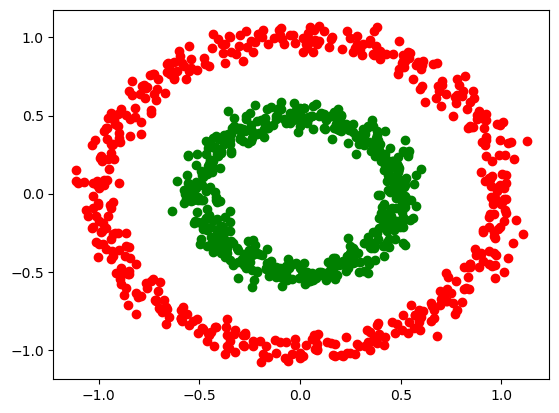

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time


X, y = datasets.make_circles(
    n_samples=1000, factor=0.5, noise=0.05, random_state=0
)

red = y == 0
green = y == 1

plt.scatter(X[red, 0], X[red, 1], c="r")
plt.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")

In [24]:
from simulation_utils.helix import *

In [30]:
x,y,z,t,_,dataset = get_vhelix(uniform = False, a = 1, b = 1, n_samples = 1500)

In [31]:
from simulation_utils.roll import *
import random
random.seed(12345)
X, t, dataset, u = make_roll(n_neighbours = 5, a = 1, b = 1, scale=0.1, n_samples = 1500, features='none')
# new_data is graph object

In [32]:
x = X[:,0]
y = X[:,1]
z = X[:,2]

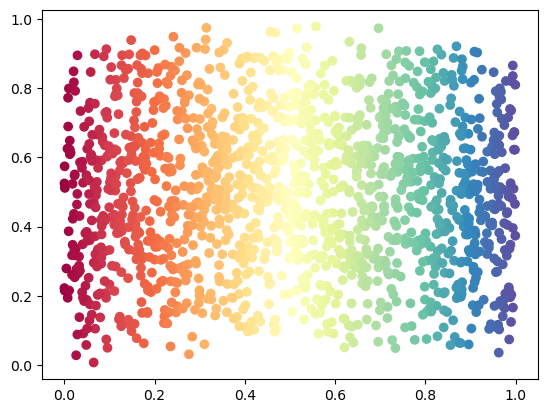

In [40]:
perfect_embeddings = np.zeros((1500,2))
perfect_embeddings[:,0] = t
perfect_embeddings[:,1] = u
plt.scatter(t, u, c = t , cmap ='Spectral')

In [34]:
import copy
y = copy.deepcopy(t)
y[t<=0.2] = 0
y[(t>0.2) & (t<=0.4)] = 1
y[(t>0.4) & (t<=0.6)] = 2
y[(t>0.6) & (t<=0.8)] = 3
y[(t>0.8) & (t<=1.0)] = 4

In [35]:
dataset.y = torch.tensor(y, dtype= torch.long)
dataset.num_classes = 5
dataset.num_features = 1500

In [43]:
data = dataset

In [37]:
from torch.nn import Linear
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from operators import *

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,out_channels = dataset.num_classes, dropout_rate=0.5,  gnn_type="normal", alpha=0, 
                 add_self_loops= True,
                 seed = 12345,
                 bias = True):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels[0],  
                             gnn_type = gnn_type,
                             alpha = alpha,
                            add_self_loops = add_self_loops,
                            bias = bias)
        self.conv2 = GCNConv(hidden_channels[0], out_channels,
                            gnn_type = gnn_type,
                            alpha = alpha,
                            add_self_loops = add_self_loops,
                            bias = bias)
   
        self.p = dropout_rate
        self.gnn_type = gnn_type 
        self.alpha = alpha
        self.seed = seed
        self.add_self_loops = add_self_loops = add_self_loops

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index)
        h = x
#         x = x.relu()
#         x = self.lin1(x)
        return x, h

model = GCN(hidden_channels=[32])
print(model)

GCN(
  (conv1): GCNConv(1500, 32)
  (conv2): GCNConv(32, 5)
)


In [44]:
# splitting the data into train and test
random.seed(12345)
train_idx = random.choices(range(0,data.num_nodes), k=int(round(data.num_nodes*0.7,0)))
test_idx = list(set(range(0,data.num_nodes)) - set(train_idx))
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = 1

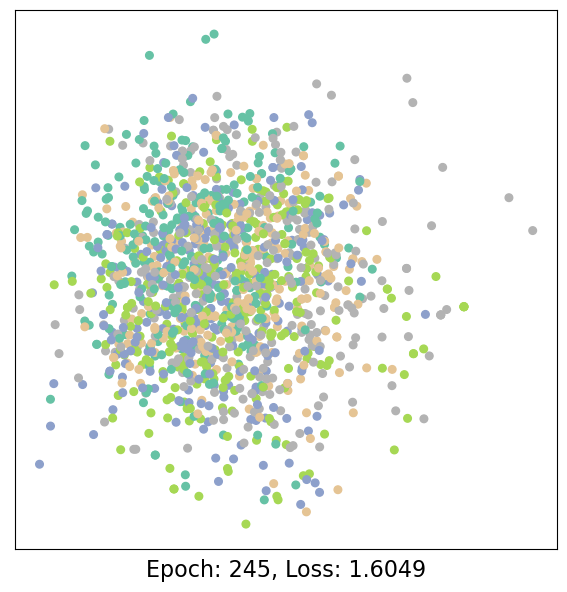

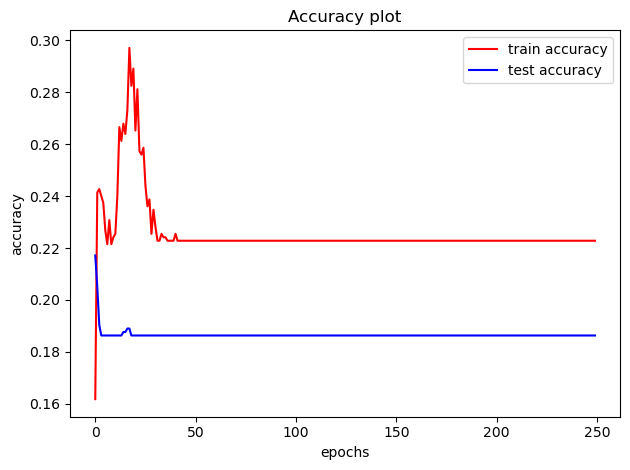

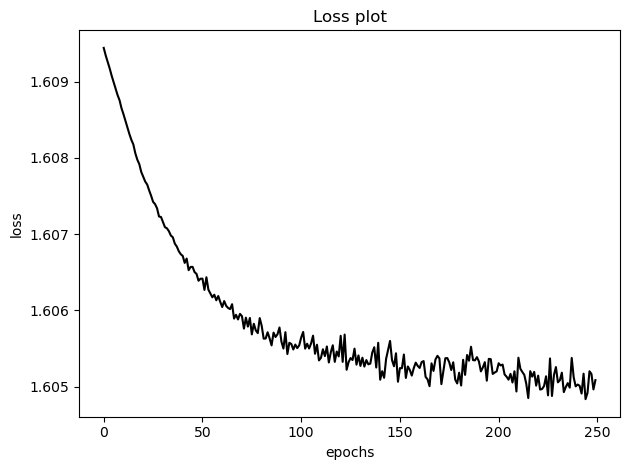

Final test accuracy: 0.19
Time to run function 'train': 9.25 seconds


In [48]:
training_set = np.random.choice(np.arange(data.num_nodes), int(round(data.num_nodes*0.7,0)))
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
from train import *
seed = 12345
experiment = 'normal'
alpha = 0.9
model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=alpha, 
                        seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(250, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

In [49]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
n_exp = 1
results = {}
bias = True

for i in np.arange(n_exp):
    seed = i
    training_set = np.random.choice(np.arange(data.num_nodes), 140)
    idx = torch.randperm(data.train_mask.shape[0])
    train_mask = data.train_mask[idx].view(data.train_mask.size())
    test_mask = ~train_mask
    idx2  =  (torch.where(test_mask)[0]).numpy()
    np.random.shuffle(idx2)
    test_mask[idx2[n_test:]] = False
    
    
    #### First model
    model = GCN(hidden_channels=[32], gnn_type = 'no', 
                        alpha=0.03, seed = np.random.choice(np.arange(10000)), bias = False)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) #didn't include weight decay
    train_acc_list, test_acc_list, loss_list, _,  _, out_temp = train(250, model, criterion, optimizer, 
                                                     x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                   test_mask),
                                                    scatter_size=30, plotting=False)
    results["roll_no" +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                'test_acc': test_acc_list[-1],
                                 'seed' : model.seed,
                                'gnn_type': "no",
                                'embedding' : out_temp,
                                'exp number': i,
                                'alpha': 0,
                                'add_self_loop' : True,
                                'dataset' : 'roll'}
    for experiment in ["normal", "diffusion"]:
        for alpha in np.arange(0,1.1,0.1):
            for loop in [True]:
                model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=alpha, add_self_loops=loop,
                        seed = seed, bias = bias)
                criterion = torch.nn.CrossEntropyLoss() 
                optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4) #didn't include weight decay

                train_acc_list, test_acc_list, loss_list, _,  _, out_temp = train(200, model, criterion, optimizer, 
                                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                       test_mask),
                                                        scatter_size=30, plotting=False)
                results['roll_' + experiment + '_' + str(alpha)+ '_loop_' + str(loop) + '_' +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                             'test_acc': test_acc_list[-1],
                                             'seed' : model.seed,
                                             'gnn_type': experiment,
                                             'embedding' : out_temp,
                                             'exp number': i,
                                            'alpha': alpha,
                                            'add_self_loop' : loop,
                                            'dataset' : 'roll'}   
                print(experiment + '_' + str(alpha)+ '_loop_' + str(loop) +'_bias_'+str(bias)+ '_' +  str(i) )


Final test accuracy: 0.98
Time to run function 'train': 2.45 seconds
Final test accuracy: 0.98
Time to run function 'train': 2.13 seconds
normal_0.0_loop_True_bias_True_0
Final test accuracy: 0.99
Time to run function 'train': 2.26 seconds
normal_0.1_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 1.99 seconds
normal_0.2_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 1.96 seconds
normal_0.30000000000000004_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 2.06 seconds
normal_0.4_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 2.16 seconds
normal_0.5_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 1.98 seconds
normal_0.6000000000000001_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 1.98 seconds
normal_0.7000000000000001_loop_True_bias_True_0
Final test accuracy: 0.98
Time to run function 'train': 1.99 seconds


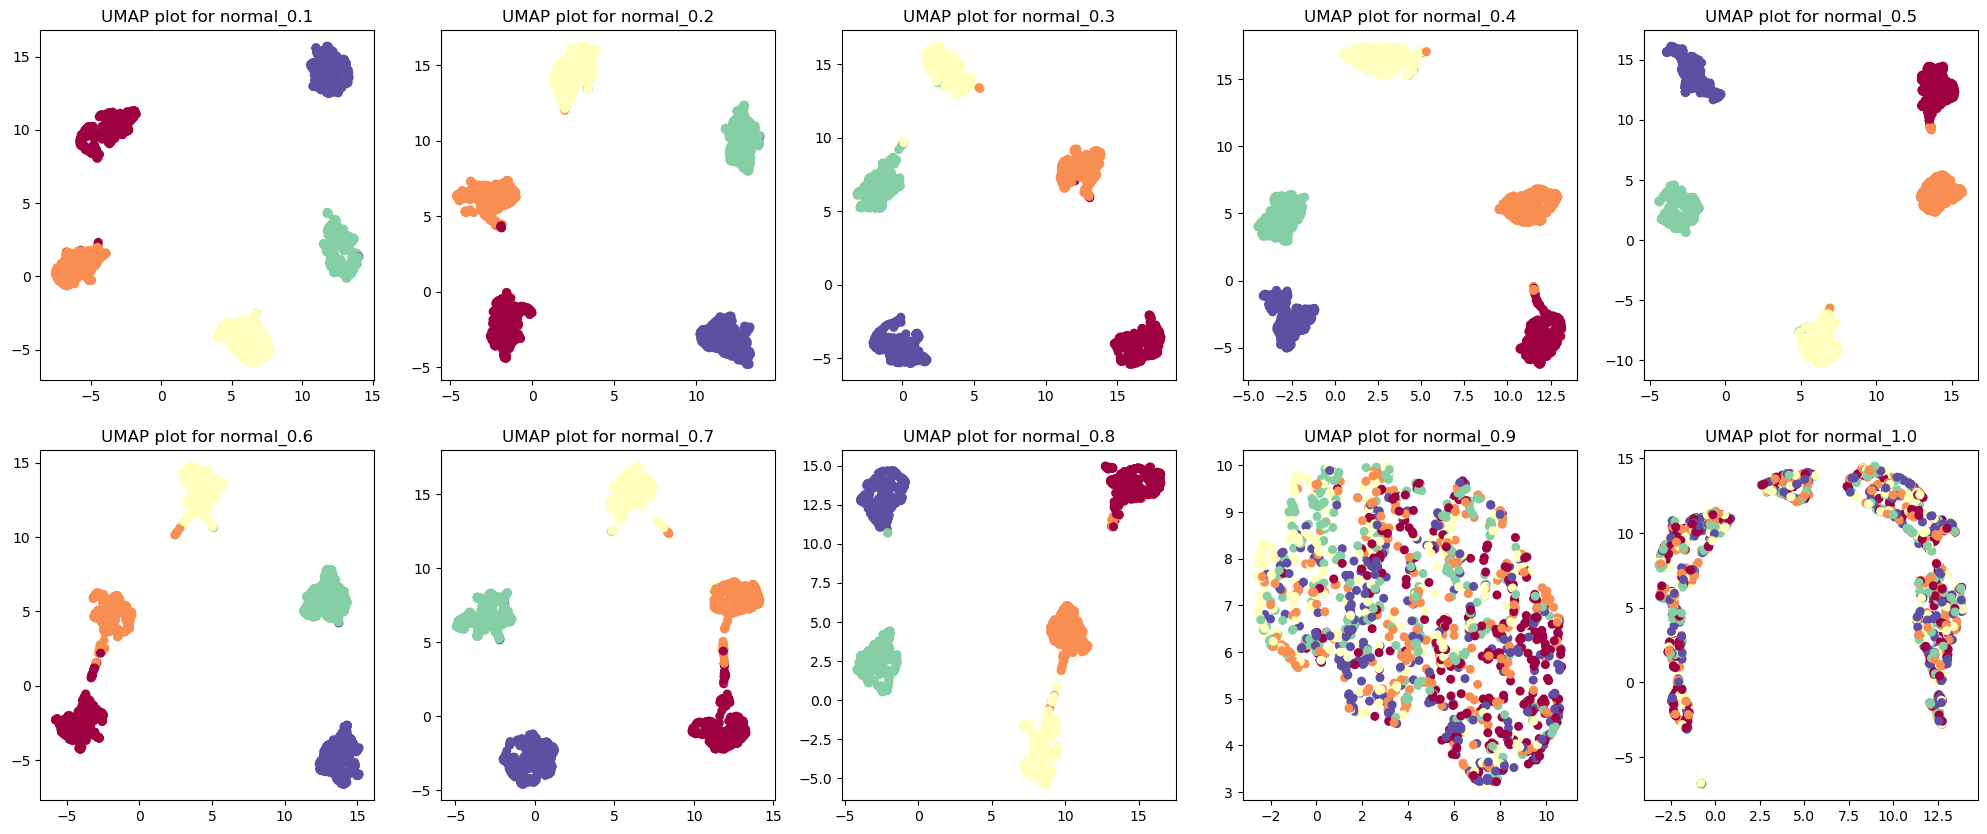

In [50]:
# !pip install umap
# !pip install umap-learn
import umap

alpha = np.arange(0,1.1,0.1)
experiment = 'normal'
# THIS MAKES A GRID and figure size as (width, height) in inches.
fig, axs = plt.subplots(2, 5, figsize = (25,10))

for i in range(10):
    temp =results['roll_' + experiment + '_' + str(alpha[i+1])+ '_loop_True_' +  str(0)] ['embedding']
    k = umap.UMAP(n_components=2).fit_transform(temp.detach().cpu().numpy())
    _ = axs[i // 5,i % 5].set_title('UMAP plot for ' + experiment + '_' + str(round(alpha[i+1],1)))
    _ = axs[i // 5,i % 5].scatter(k[:, 0], k[:, 1], s=30, c=data.y,  cmap="Spectral") # marker= all_poss[data.y[i]]

# Show the graph
plt.show()

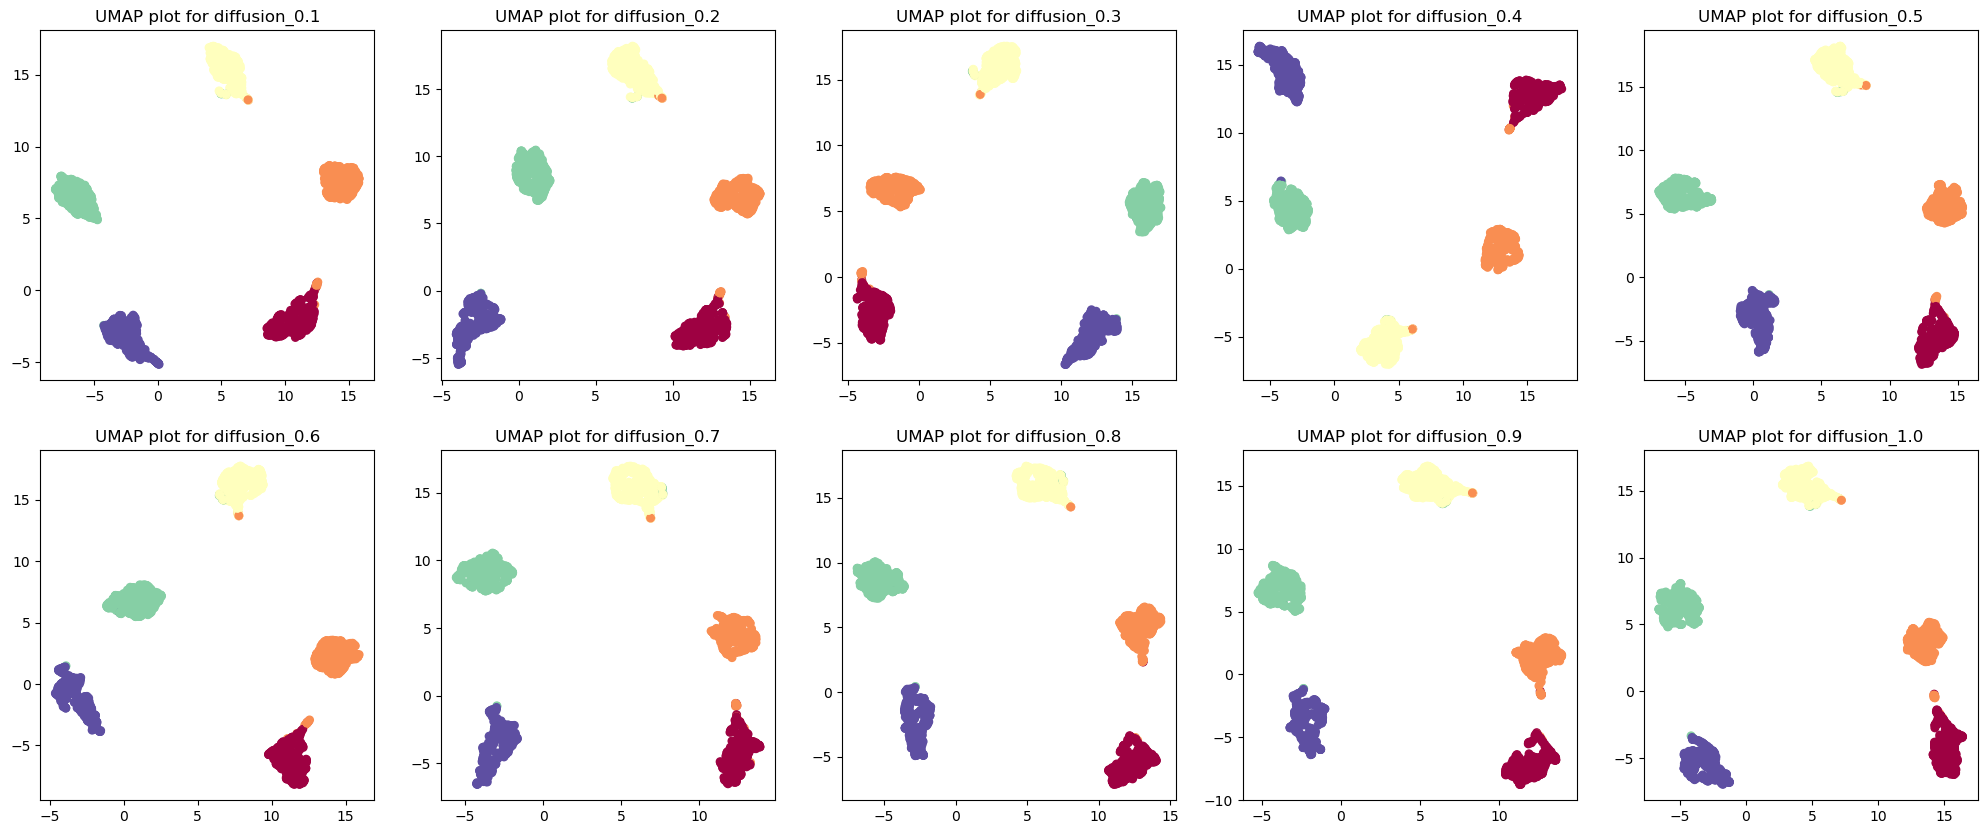

In [51]:
# !pip install umap
# !pip install umap-learn
import umap

alpha = np.arange(0,1.1,0.1)
experiment = 'diffusion'
# THIS MAKES A GRID and figure size as (width, height) in inches.
fig, axs = plt.subplots(2, 5, figsize = (25,10))

for i in range(10):
    temp =results['roll_' + experiment + '_' + str(alpha[i+1])+ '_loop_True_' +  str(0)] ['embedding']
    k = umap.UMAP(n_components=2).fit_transform(temp.detach().cpu().numpy())
    _ = axs[i // 5,i % 5].set_title('UMAP plot for ' + experiment + '_' + str(round(alpha[i+1],1)))
    _ = axs[i // 5,i % 5].scatter(k[:, 0], k[:, 1], s=30, c=data.y,  cmap="Spectral") # marker= all_poss[data.y[i]]

# Show the graph
plt.show()

In [52]:
# local geometry
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
res = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        res[i,j] = neighbor_kept_ratio_eval(data,results['roll_' + exp[j] + '_' + str(alpha[i+1])+ '_loop_True_' + str(0)]['embedding'].detach().numpy(), n_neighbors = 5)

df = pd.DataFrame(res)
df.columns = exp
df

,normal,diffusion
0,0.235065,0.174536
1,0.219661,0.184819
2,0.210547,0.193527
3,0.205807,0.201262
4,0.214003,0.208673
5,0.228744,0.220111
6,0.236488,0.225255
7,0.238014,0.228044
8,0.088782,0.235204
9,0.051216,0.235473


In [53]:
# global geometry
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
corr = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        _,_,corr[i,j],_ = spearman_correlation_eval(perfect_embeddings,results['roll_' + exp[j] + '_' + str(alpha[i+1])+ '_loop_True_' + str(0)]['embedding'].detach().numpy())

corr = pd.DataFrame(corr)
corr.columns = exp
corr

,normal,diffusion
0,0.318123,0.337861
1,0.340647,0.339337
2,0.318305,0.337066
3,0.342188,0.333803
4,0.341238,0.332367
5,0.349477,0.332181
6,0.361276,0.331043
7,0.362803,0.329110
8,0.023421,0.329579
9,0.030523,0.327794


In [80]:
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
dens = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        Y = results['roll_' + exp[j] + '_' + str(alpha[i+1])+ '_loop_True_' + str(0)]['embedding'].detach().numpy()
        dens[i,j] = eval_density_preserve(X,Y, sigma = 1.0, min_dist = 1e-12)
dens = pd.DataFrame(dens)

dens.columns = exp
dens

,normal,diffusion
0,-0.121279,-0.118306
1,-0.076309,-0.124132
2,-0.049731,-0.123484
3,-0.038612,-0.090645
4,-0.096356,-0.111467
5,-0.127353,-0.109164
6,-0.010779,-0.098052
7,-0.166414,-0.107969
8,0.060843,-0.096007
9,0.023852,-0.079999


In [81]:
from models.grace import *
from models.train_models import train_grace
from models.baseline_models import *

In [82]:
out = {}
alpha = np.arange(0,1.1,0.1)
for i in np.arange(10):
    model = train_grace(dataset, 32, 2, n_layers=1, tau=0.5,
                epochs=200, wd=1e-3, lr=1e-2, fmr=0.2, edr =0.5,
                proj="nonlinear-hid", name_file="test", device=None,
                gnn_type="symmetric", alpha=alpha[i], beta = 1,add_self_loops= True)
    out_tmp = model.get_embedding(dataset)
    out['normal' '_' + str(alpha[i+1])] = out_tmp

=== train GRACE model ===
Epoch=000, loss=8.0057
Epoch=001, loss=8.0042
Epoch=002, loss=8.0004
Epoch=003, loss=7.9921
Epoch=004, loss=7.9756
Epoch=005, loss=7.9531
Epoch=006, loss=7.9215
Epoch=007, loss=7.8727
Epoch=008, loss=7.8216
Epoch=009, loss=7.7451
Epoch=010, loss=7.6814
Epoch=011, loss=7.6158
Epoch=012, loss=7.5528
Epoch=013, loss=7.5050
Epoch=014, loss=7.4679
Epoch=015, loss=7.4397
Epoch=016, loss=7.4436
Epoch=017, loss=7.4270
Epoch=018, loss=7.4218
Epoch=019, loss=7.4361
Epoch=020, loss=7.4327
Epoch=021, loss=7.4386
Epoch=022, loss=7.4129
Epoch=023, loss=7.4318
Epoch=024, loss=7.4129
Epoch=025, loss=7.4229
Epoch=026, loss=7.4088
Epoch=027, loss=7.3761
Epoch=028, loss=7.4004
Epoch=029, loss=7.3965
Epoch=030, loss=7.3840
Epoch=031, loss=7.3784
Epoch=032, loss=7.3832
Epoch=033, loss=7.3768
Epoch=034, loss=7.3821
Epoch=035, loss=7.3625
Epoch=036, loss=7.3664
Epoch=037, loss=7.3774
Epoch=038, loss=7.3699
Epoch=039, loss=7.3754
Epoch=040, loss=7.3606
Epoch=041, loss=7.3696
Epoch=04

In [83]:
alpha = np.arange(0,1.1,0.1)
for i in np.arange(10):
    model = train_grace(dataset, 32, 2, n_layers=1, tau=0.5,
                epochs=200, wd=1e-2, lr=1e-3, fmr=0.2, edr =0.5,
                proj="nonlinear-hid", name_file="test", device=None,
                gnn_type="RW", alpha=alpha[i], beta = 1,add_self_loops= True)
    out_tmp = model.get_embedding(dataset)
    out['diffusion' '_' + str(alpha[i+1])] = out_tmp

=== train GRACE model ===
Epoch=000, loss=8.0060
Epoch=001, loss=8.0060
Epoch=002, loss=8.0060
Epoch=003, loss=8.0060
Epoch=004, loss=8.0060
Epoch=005, loss=8.0060
Epoch=006, loss=8.0060
Epoch=007, loss=8.0060
Epoch=008, loss=8.0060
Epoch=009, loss=8.0060
Epoch=010, loss=8.0060
Epoch=011, loss=8.0060
Epoch=012, loss=8.0060
Epoch=013, loss=8.0060
Epoch=014, loss=8.0060
Epoch=015, loss=8.0060
Epoch=016, loss=8.0060
Epoch=017, loss=8.0060
Epoch=018, loss=8.0060
Epoch=019, loss=8.0060
Epoch=020, loss=8.0060
Epoch=021, loss=8.0060
Epoch=022, loss=8.0060
Epoch=023, loss=8.0060
Epoch=024, loss=8.0060
Epoch=025, loss=8.0060
Epoch=026, loss=8.0060
Epoch=027, loss=8.0060
Epoch=028, loss=8.0060
Epoch=029, loss=8.0060
Epoch=030, loss=8.0060
Epoch=031, loss=8.0060
Epoch=032, loss=8.0060
Epoch=033, loss=8.0060
Epoch=034, loss=8.0060
Epoch=035, loss=8.0060
Epoch=036, loss=8.0060
Epoch=037, loss=8.0060
Epoch=038, loss=8.0060
Epoch=039, loss=8.0060
Epoch=040, loss=8.0060
Epoch=041, loss=8.0060
Epoch=04

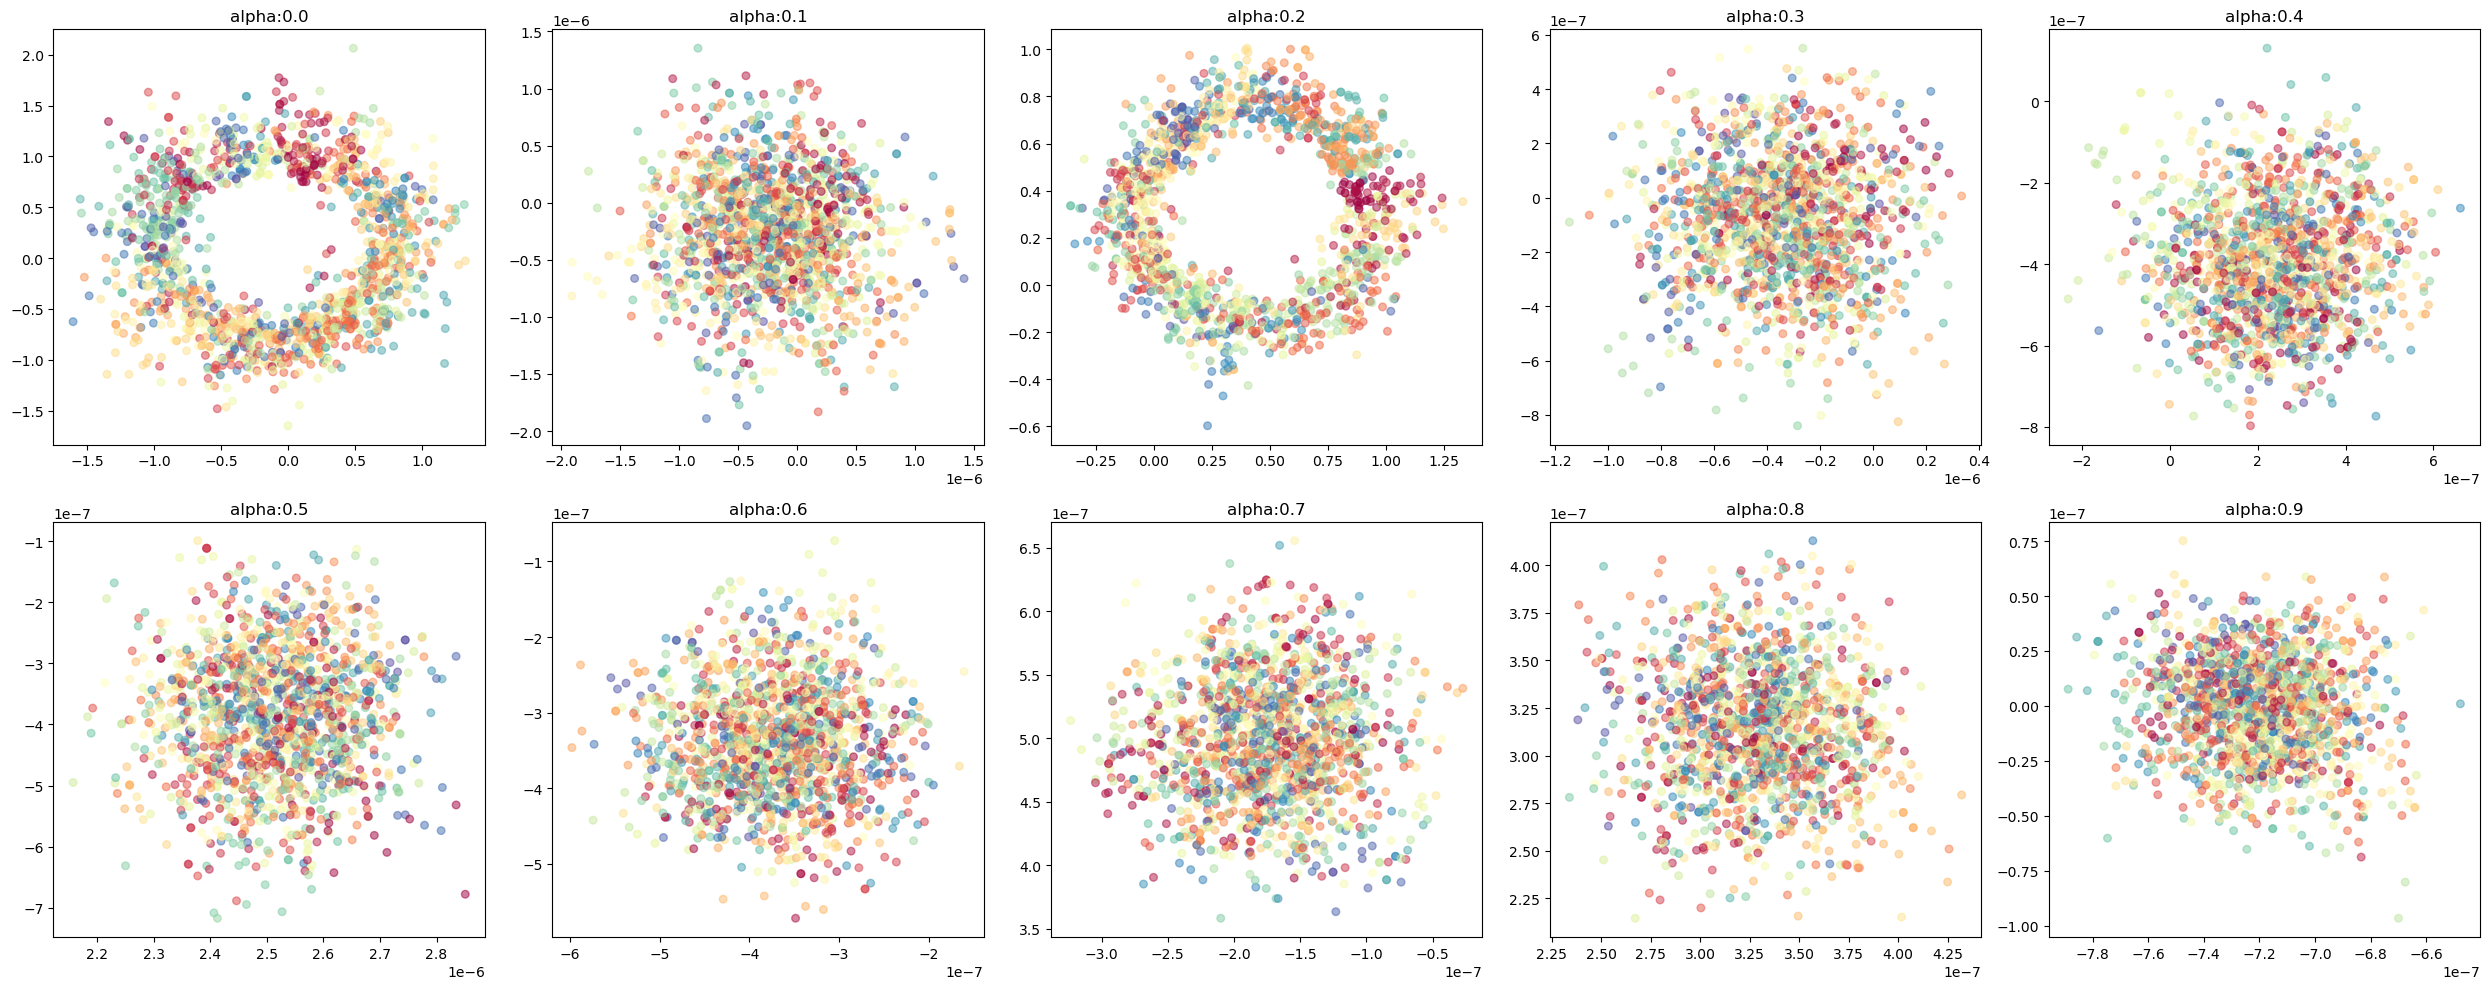

In [84]:
# symmetric
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    temp =out['normal_'+ str(alpha[i+1])].detach().numpy()
    _ = ax.scatter(temp[:,0], temp[:,1], c = t, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()

In [85]:
# local geometry
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
res = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        res[i,j] = neighbor_kept_ratio_eval(data,out[exp[j] + '_' + str(alpha[i+1])].detach().numpy(), n_neighbors = 5)

df = pd.DataFrame(res)
df.columns = exp
df

,normal,diffusion
0,0.086112,0.045078
1,0.050699,0.049719
2,0.104118,0.051383
3,0.047500,0.048407
4,0.043467,0.050458
5,0.041089,0.077476
6,0.047071,0.041342
7,0.046852,0.046548
8,0.045262,0.048331
9,0.047254,0.041580


In [86]:
# global geometry
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
corr = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        _,_,corr[i,j],_ = spearman_correlation_eval(perfect_embeddings,out[exp[j] + '_' + str(alpha[i+1])].detach().numpy())

corr = pd.DataFrame(corr)
corr.columns = exp
corr

,normal,diffusion
0,0.077966,0.074094
1,0.002807,-0.004990
2,0.065008,0.015482
3,0.032489,0.021496
4,-0.012643,0.018559
5,-0.002803,0.104441
6,0.016671,0.003912
7,-0.006421,0.015781
8,0.003929,0.037081
9,-0.010794,0.040778


In [87]:
alpha = np.arange(0,1.1,0.1)
exp = ['normal','diffusion']
dens = torch.zeros((10,2))
for j in range(2):
    for i in range(10):       
        Y = out[exp[j] + '_' + str(alpha[i+1])].detach().numpy()
        dens[i,j] = eval_density_preserve(X,Y, sigma = 1.0, min_dist = 1e-3)
dens = pd.DataFrame(dens)
dens.columns = exp
dens

,normal,diffusion
0,0.046705,0.061993
1,-0.048204,0.083596
2,0.045224,-0.005791
3,0.052886,0.004444
4,-0.099992,-0.025940
5,-0.044243,-0.040271
6,-0.005766,-0.021313
7,-0.019133,-0.004454
8,0.054420,0.124577
9,-0.013291,-0.012392
